In [1]:
import sys
sys.path.append('/scratch/msc24h18/msc_project/aihwkit/src/')

In [2]:
import pickle
import os
from msc_project.utils.fit_piecewise import get_fit
import msc_project.utils.data_utils as du
import msc_project.utils.plot_utils as pu
from msc_project.utils.asymmetric_pulsing import plot_asymmetric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aihwkit.utils.visualization import plot_device, plot_device_compact

plt.style.use('ggplot')


SEED = 2024
PATH_DATASET = os.path.join("/scratch/msc24h18/msc_project/data", "DATASET")

In [3]:
DATA_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID294YR'

summary_files = du.get_summary_files(DATA_PATH)
print(f"Found {len(summary_files)} summary files")

Found 3 summary files


In [4]:
summaries = [du.read_summary_file(f)[0] for f in summary_files]
_, device_configs, model_responses = zip(*[get_fit(f) for f in summary_files])
device_configs = list(device_configs)
model_responses = list(model_responses)

ID294YR - 11:05:17


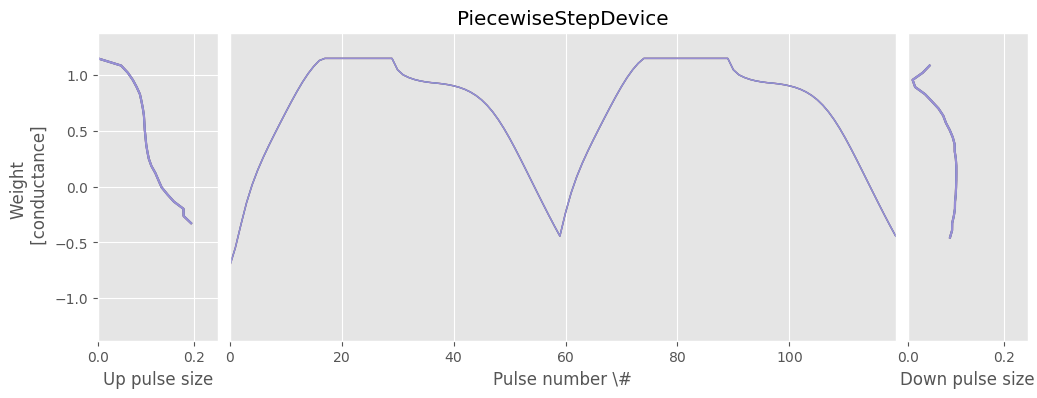

ID294YR - 11:13:50


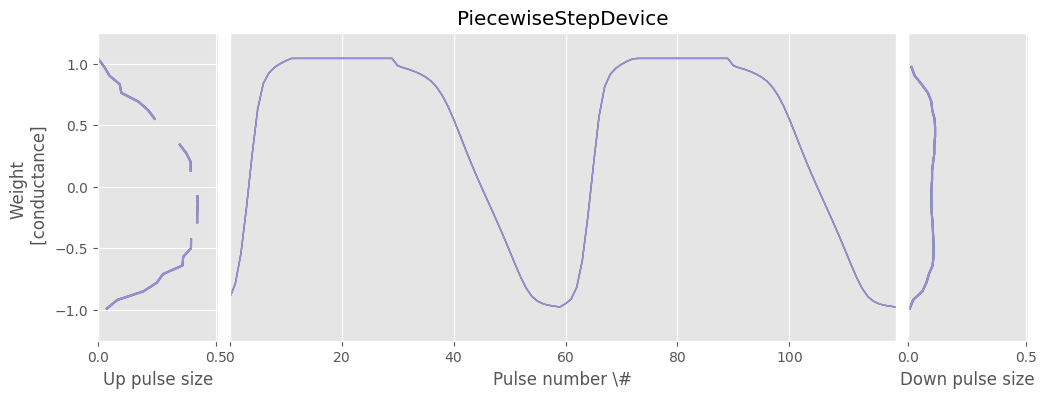

ID294YR - 11:21:56


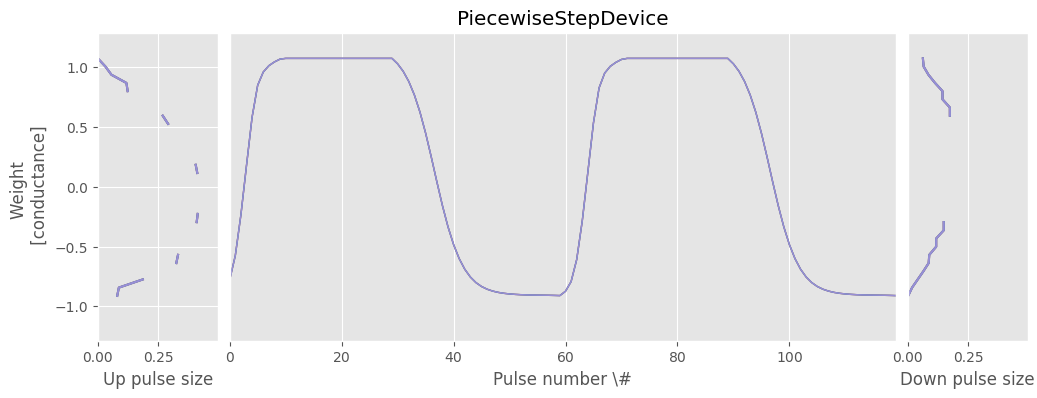

In [5]:
for s, d in zip(summaries, device_configs):
    print(f"{s['device_id']} - {s['test_time']}")
    fig = plot_device_compact(d, n_steps=30)
    plt.show()

ID294YR - 11:13:50


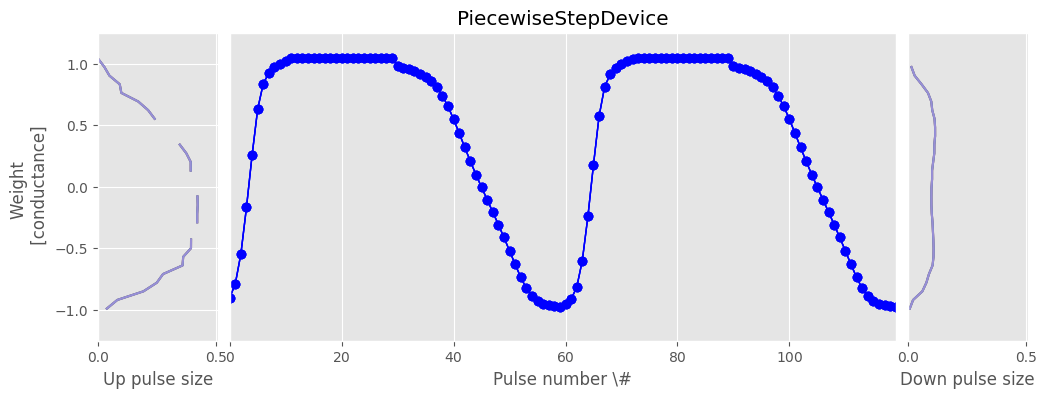

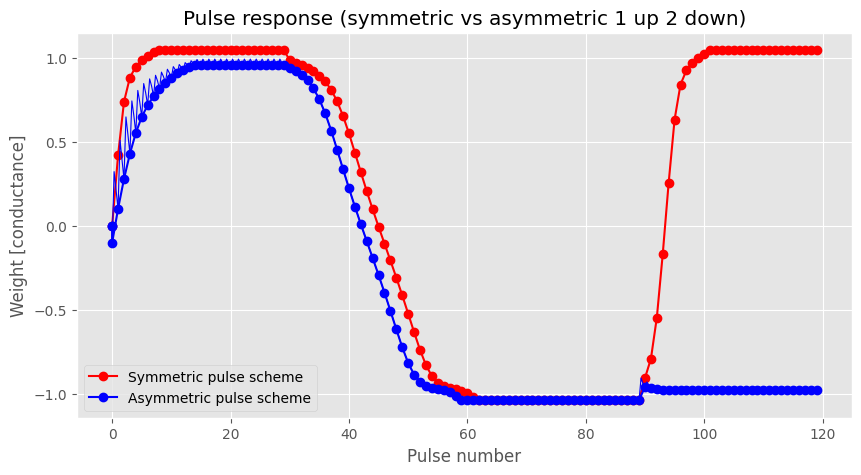

In [6]:
IDX = 1

s = summaries[IDX]
dc = device_configs[IDX]

print("ID294YR -", s['test_time'])
plot_device_compact(dc, n_steps=30, marker='o', color='b')

ax = plot_asymmetric(dc, asym_up=1, asym_down=2, w_init=0, n_steps=60)
plt.show()

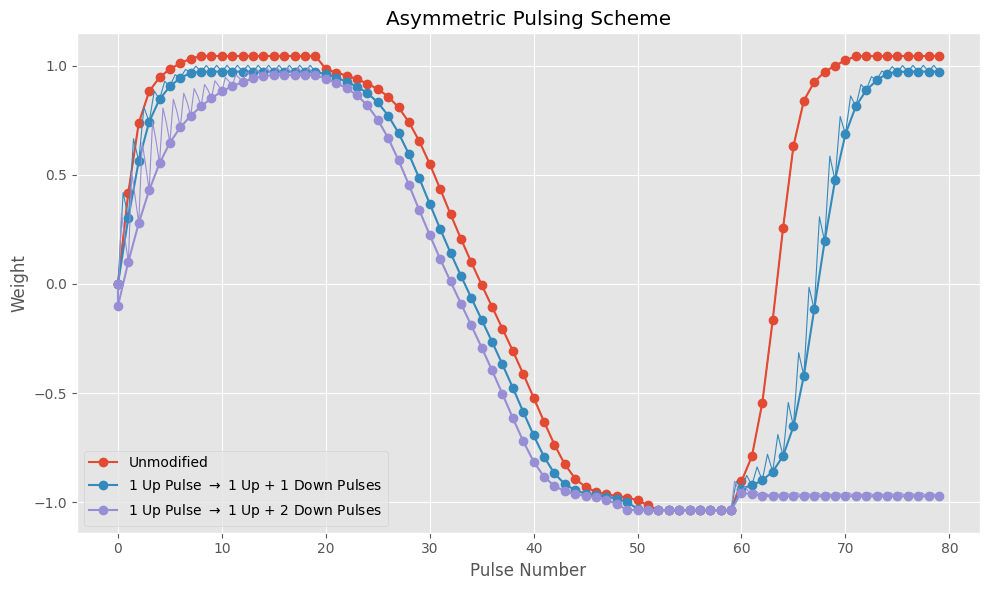

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

downs = np.arange(0, 3)
# colors = plt.cm.plasma(np.linspace(0, 1, len(downs)))
colors = [f"C{i}" for i in range(len(downs))]

for color, down in zip(colors, downs):
    if down == 0:
        label='Unmodified'
    else:
        label=f'1 Up Pulse $\\rightarrow$ 1 Up + {down} Down Pulses'
    plot_asymmetric(dc, ax, n_steps=40, asym_up=1, asym_down=down, w_init=0,
                    asym_only=True, label=label, color=color)
    
ax.set(xlabel="Pulse Number", ylabel="Weight", title="Asymmetric Pulsing Scheme")
ax.legend()
plt.tight_layout()
plt.savefig('/scratch/msc24h18/msc_project/results/report_figures/asymmetric_pulsing_scheme.png')
plt.show()

In [8]:
import torch

DATA_DIR = '/scratch/msc24h18/msc_project/tmpAll/tmp4'

summary_files = du.get_summary_files(DATA_DIR)
print(summary_files)
weights_files = du.get_files(DATA_DIR, 'pkl', 'weights')

summaries = [du.read_summary_file(f)[0] for f in summary_files]
weights = [pickle.load(open(f, 'rb')) for f in weights_files]

# first layer is split into two (256,392) layers, so combine them into one (256,784)
for w in weights:
    for w_i in w:
        t1 = w_i['0.analog_module.array.0.0'][0]
        t2 = w_i['0.analog_module.array.1.0'][0]
        t3 = torch.cat([t1, t2], dim=1)
        new_weight = (t3, None)
        w_i.pop('0.analog_module.array.0.0', None)
        w_i.pop('0.analog_module.array.1.0', None)
        w_i['0.analog_module'] = new_weight
        w_i.move_to_end('0.analog_module', last=False)

['/scratch/msc24h18/msc_project/tmpAll/tmp4/asymmetric/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(2)]20240919111221/Summary.dat', '/scratch/msc24h18/msc_project/tmpAll/tmp4/mp/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(2)]20240919111221/Summary.dat']


In [11]:
def filter_data(summaries, weights, filter_col='device_id', filter_val='ID294YR'):
    filtered_summaries = []
    filtered_weights = []
    for s, w in zip(summaries, weights):
        if s[filter_col] == filter_val:
            filtered_summaries.append(s)
            filtered_weights.append(w)

    return filtered_summaries, filtered_weights

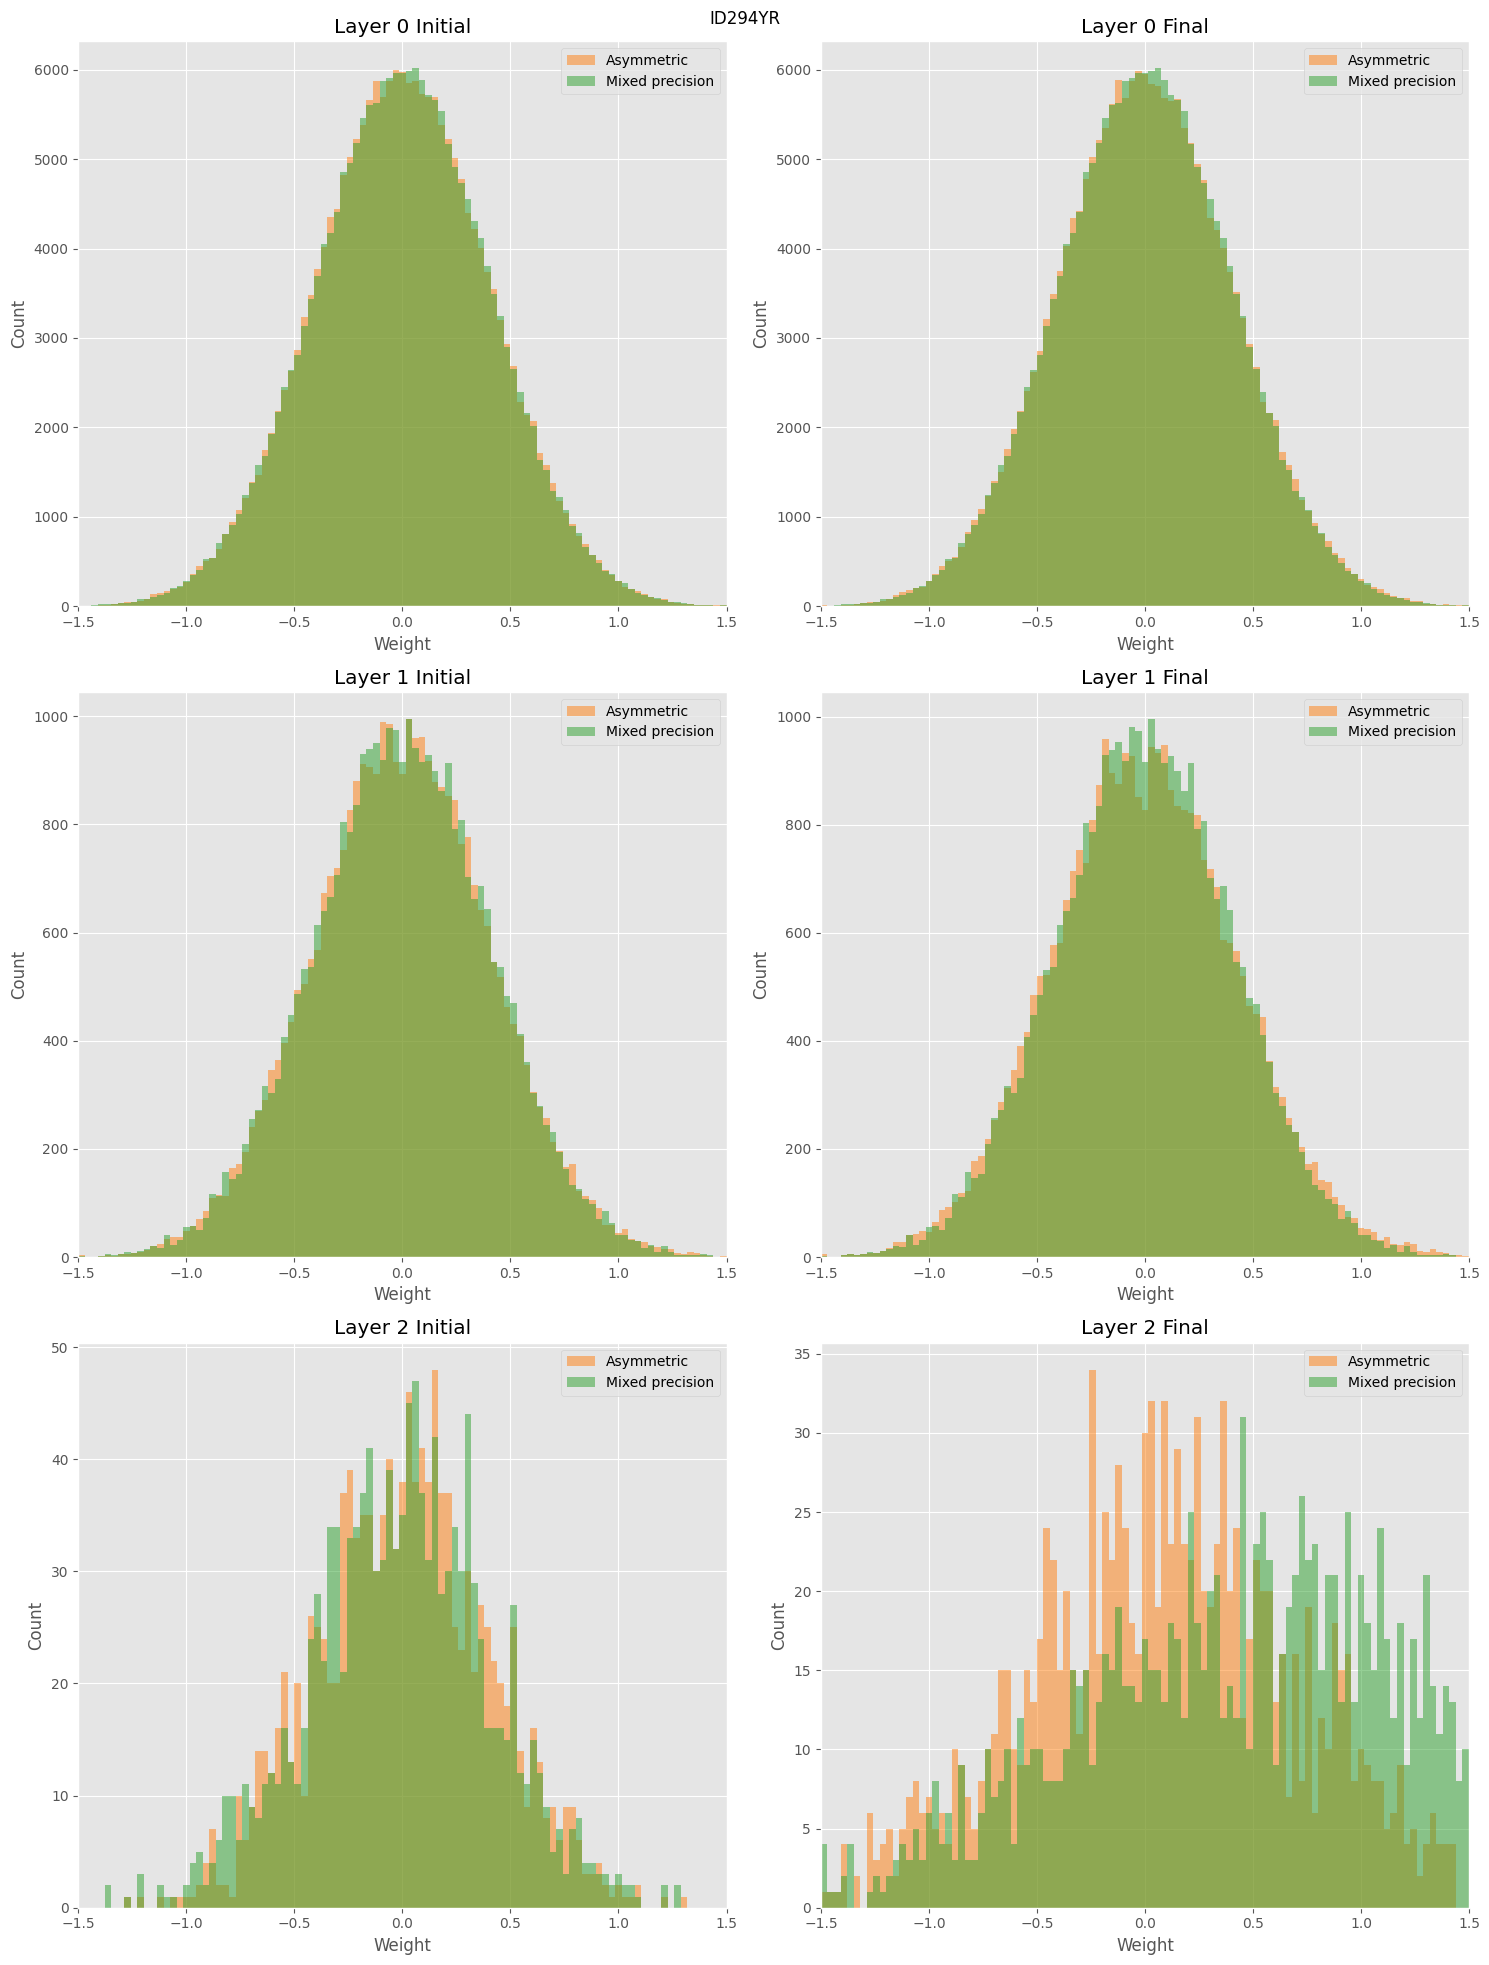

In [ ]:
filtered_summaries, filtered_weights = filter_data(summaries, weights, filter_col='device_id', filter_val='ID294YR')
filtered_summaries[0]['type'] = 'Asymmetric'
filtered_summaries[1]['type'] = 'Mixed precision'
# filtered_summaries[2]['type'] = 'Mixed precision'

# filtered_summaries = [filtered_summaries[i] for i in [1, 2, 0]]
# filtered_weights = [filtered_weights[i] for i in [1, 2, 0]]

colors = plt.cm.rainbow(np.linspace(0, 1, len(filtered_summaries)))
pu.plot_weight_hist(filtered_weights, labels=[s['type'] for s in filtered_summaries],
                 suptitle='ID294YR', colors=['#ff7f0e', '#2ca02c', '#1f77b4', ])
# pu.animate_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle='ID294YR')